In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, beta
import pandas as pd
from scipy.optimize import differential_evolution

from refnx.reflect import Structure, Component, SLD, Slab, ReflectModel
from refnx.reflect.interface import Erf
from refnx.analysis import Parameters, Parameter, possibly_create_parameter, PDF, Objective, CurveFitter, process_chain
from maxent import MaxEntVFP, MaxEntVFP_alternate
from refnx.dataset import ReflectDataset

from Code.Utilities import unpack_values


In [ ]:
data = ReflectDataset('Data/PNIPAM d2o 25C.dat')

In [ ]:
data.plot()
plt.yscale('log')

In [4]:
prior_values = pd.read_csv('SiO2 characterisation.csv',
                           index_col=0,
                           header=0,
                           names=['silica thick', 'silica SLD', 
                                  'silica-SiO2 rough', 'silica vfsolv',
                                  'PNIPAM thick', 'PNIPAM SLD',
                                  'PNIPAM vfsolv', 'PNIPAM volume'])

polymer_ads_amt, polymer_ads_amt_bounds, polymer_ads_amt_dist       = unpack_values(prior_values['PNIPAM volume'])
sio2_thickness, sio2_thickness_bounds, sio2_thickness_dist          = unpack_values(prior_values['silica thick'])
sio2_sld, sio2_sld_bounds, sio2_sld_dist                            = unpack_values(prior_values['silica SLD'])
sio2_vfsolv, sio2_vfsolv_bounds, sio2_vfsolv_dist                   = unpack_values(prior_values['silica vfsolv'])
si_sio2_roughness, si_sio2_roughness_bounds, si_sio2_roughness_dist = unpack_values(prior_values['silica-SiO2 rough'])

sio2_poly_rough = 1

prior_values

,silica thick,silica SLD,silica-SiO2 rough,silica vfsolv,PNIPAM thick,PNIPAM SLD,PNIPAM vfsolv,PNIPAM volume
q1,16.578260,3.293231,10.844933,0.076289,125.240686,0.575200,0.097191,110.527870
q2,18.559324,3.455169,12.826823,0.091450,125.762557,0.589260,0.110819,111.840543
q3,20.867145,3.616602,14.443033,0.107877,126.331105,0.606567,0.121890,113.472781
stdev,1.094103,0.082492,0.917883,0.008058,0.278168,0.008002,0.006301,0.751253


In [5]:
# Materials
si      = SLD(2.07, 'si')
sio2    = SLD(sio2_sld, 'sio2')
polymer = SLD(0.8, 'PNIPAM')
solvent = SLD(6.2, 'd2o')
polymer.real.setp(vary=True, bounds=(0.72, 1.25))
solvent.real.setp(vary=True, bounds=(6.15, 6.35))

# Silicon
si_l          = si(0, 0)

# Silica
sio2_l        = sio2(sio2_thickness, si_sio2_roughness)
sio2_l.thick.setp (vary=True, bounds=sio2_thickness_dist)
sio2_l.sld.real.setp (vary=True, bounds=sio2_sld_dist)
sio2_l.vfsolv.setp (vary=True, value=sio2_vfsolv,
                    bounds=sio2_vfsolv_dist)
sio2_l.rough.setp (vary=True, value=si_sio2_roughness,
                   bounds=si_sio2_roughness_dist)

# adsorbed amount
# If you use MaxEntVFP then you should set vary=False. In addition you should
# not use a distribution that has closed support (e.g. truncnorm).
# It's easy for the area under the VFP to exceed distribution support.

# If you use MaxEntVFP_alternate then you can enable vary=True, if desired. You
# can also use distributions with closed support.
gamma = Parameter(polymer_ads_amt, 'adsorbed amount', vary=True)
gamma.bounds = PDF(polymer_ads_amt_dist)
# gamma.bounds = PDF(norm(loc=111.8, scale=0.74))

In [6]:
# x = np.linspace(106, 120, 101)
# plt.plot(x, gamma.bounds.rv.pdf(x))
# plt.plot(x, norm.pdf(x, loc=111.8,scale=0.74))

In [7]:
lslab = polymer(13.5, 1)
lslab.thick.setp(vary=True, bounds=(2, 25))
lslab.vfsolv.setp(0.217, vary=True, bounds=(0.1, 0.8))
lslab.rough.setp(1, vary=True, bounds=(1, 4))

/Users/anz/miniconda3/envs/dev3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


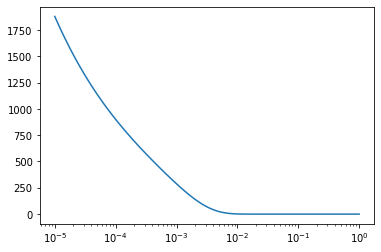

In [8]:
# 1/alpha scales the entropy term.
dist = beta(0.7, 500)
alpha = Parameter(0.01, 'alpha', vary=True)
alpha.bounds = PDF(dist)

_x = np.geomspace(1e-5, 1, 101)
plt.plot(_x, dist.pdf(_x))
plt.xscale('log');

In [9]:
# if the dry thickness is 100, and the total extent that we'll model
# is 1000, then a good guess for an average vf = 100/1000. So set
# mj to that value.

brush = MaxEntVFP_alternate(gamma, polymer, mj=0.1, npixels=70, left_slabs=(lslab,), alpha=alpha,
                  monotonic=True, max_slab_size=40)

# gamma.setp(vary=False)
# brush = MaxEntVFP(gamma, polymer, mj=0.1, extent=1800, left_slabs=(lslab,), alpha=alpha,
#                   monotonic=True, microslab_max_thickness=25)
for p in brush.vff:
    p.setp(1, vary=True, bounds=(0.5, 1.0))
    
brush.vff[0].setp(0.1, bounds=(0.05, 0.4))

In [10]:
brush.gamma(), brush.adsorbed_amount.value

(111.84054281225346, 111.84054281225347)

111.84054281225346


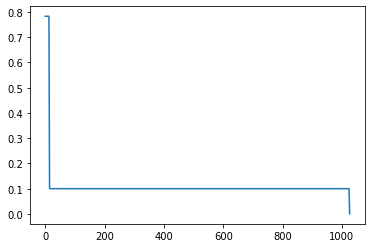

In [11]:
plt.plot(*brush.profile());
print(brush.gamma())

In [12]:
s = si | sio2_l | lslab | brush | solvent(0, 0)

s.contract = 1.5
model = ReflectModel(s, bkg=8e-7, dq=8.55)
model.dq_type = 'constant'
model.scale.setp(0.75, vary=True, bounds=(0.7, 0.8))
model.bkg.setp(vary=True, bounds=(7e-7, 1.3e-6))
model.threads = 1

In [13]:
objective = Objective(model, data)

In [14]:
fitter = CurveFitter(objective)

In [15]:
fitter.fit('differential_evolution', target='nlpost', popsize=3,);
#            x0=np.array(objective.varying_parameters()));

1000it [16:15,  1.05it/s]/Users/anz/miniconda3/envs/dev3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
1000it [16:15,  1.02it/s]


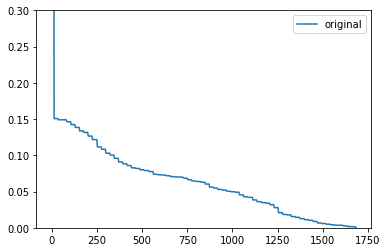

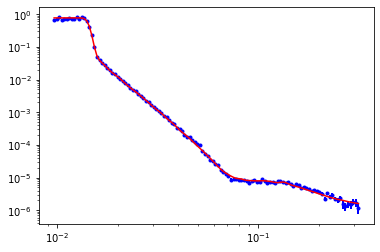

In [19]:
plt.plot(*brush.profile(), label='original');
plt.legend();
# plt.xlim(0, 1000)
plt.ylim(0, 0.3)
objective.plot()
plt.yscale('log')
plt.xscale('log')
# plt.plot(data.x, (objective.generative() - data.y)/data.y_err)

In [ ]:
fitter.initialise('jitter')

In [ ]:
fitter.sample(800, nthin=1, pool=-1);

In [ ]:
fitter.reset()
# fitter.sample(1, pool=1);

In [ ]:
fitter.sample(20, nthin=2000, pool=-1);

In [ ]:
plt.plot(*brush.profile());
plt.xlim(0, 2000)
plt.ylim(0, 0.3)
objective.plot()
plt.yscale('log')
plt.xscale('log')
# profile_alternate = brush.profile()

In [17]:
objective.chisqr()

227.43101604445306